# **EXPLORATORY DATA ANALYSIS**

In [3]:
#pip install -r requirements.txt

In [4]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import re #regular expressions library for text manipulation
import string
import numpy as np
import unicodedata
import ast

from prettytable import PrettyTable

import csv
import os
import random

from glob import glob

#NLP libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy import displacy
from spacy.lang.en import English
import spacymoji
import emoji
import contractions

import itertools
from autocorrect import Speller

#for wordclouds
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
sns.set_style('whitegrid')

In [2]:
#additional nlp models
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 451.7 kB/s eta 0:00:0000:0100:03

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [11]:
def clean_comments (filepath):
    """
    import comments from csv file into pandas dataframe,
    
    and carry out initial cleaning including removing deleted comments,
    
    correcting datetime data type, remove unwanted columns like `isSubmitter`,
    
    remove duplicates, etc
    
    """
    #import data
    df = pd.read_csv(filepath, low_memory = False)
    
    #remove deleted comments if any
    df = df[df.Body != '[deleted]']
    df = df[df.Body != '[removed]']
    df = df.dropna(subset=['Body'])
    
    #remove comments with missing id
    drop_index = df[df.isSubmitter.isnull()].index
    df.drop(drop_index, inplace = True)
    
    #remove duplicates if any
    df = df.drop_duplicates(subset =['ID'], ignore_index = True)
    df.reset_index (drop = True, inplace = True)
    
    #correct data types and column label
    df['Date_Created'] = pd.to_datetime(df['Date_Created'])
    df['year'] = df['Date_Created'].dt.year
    df['Score'] = df['Score'].astype('int') 
    df.rename(columns = {'Author_ID': "Author"}, inplace = True) 
    
    #rename 'Body' column to text
    df.rename(columns = {'Body': 'long_text',
                        'Date_Created': 'date_created'}, inplace = True)
    
    #remove unnecessary columns
    df.drop(columns = ['Unnamed: 0', 'Author', 'Score',
       'Parent_ID', 'Submission_ID', 'Subreddit', 'isParent', 'isSubmitter'], inplace = True)
    
    #remove any extra whitespace in column labels
    df.columns = df.columns.str.strip()
    
    #include column to denote row is comment entry
    df['text_type'] = 'comment'
    
    #rearrange column order
    df = df[['text_type','ID','date_created', 'year', 'long_text']]
    
    
        
    return df



In [10]:
def clean_submissions(filepath):
    """
    import submissions/posts from csv file into pandas dataframe,
    
    and carry out initial cleaning including removing deleted comments,
    
    correcting datetime data type, remove unwanted columns like `Unnamed`,
    
    remove duplicates, etc
    
    """
    df = pd.read_csv(filepath, low_memory = False)
    
    #drop duplicate posts
    df = df.drop_duplicates(subset =['ID'], ignore_index = True)
    df.reset_index (drop = True, inplace = True)
    
    #create column for post title + post text
    df['long_text'] = df['Title']+ " " +df['Post Text'].fillna('')
    
    #adjust data types
    df['Date Created'] = pd.to_datetime(df['Date Created'])
    df['year'] = df['year'].astype('int')
    
    #rename columns
    df.rename(columns = {'Date Created': 'date_created'}, inplace = True)
    
    #remove unwanted columns
    df = df.drop(columns = ['Unnamed: 0', 'Title','Post Text', 'Score',
       'Total Comments', 'Post URL', 'SubReddit','Unnamed: 0.1'])
    
    #include column to denote row is comment entry
    df['text_type'] = 'submission'
    
    #reorder columns - 'ID', 'Post Text'
    df  = df[['text_type','ID', 'date_created','year', 'long_text']]
    
    return df
    

In [4]:
#access dataset files
folder_path = os.path.join("..", "Data")
file_type = "*.csv"

#list of dataset file paths
document_path = glob(os.path.join(folder_path, file_type))

document_path

['../Data/subset_sample_no_label.csv',
 '../Data/filtered_corpus.csv',
 '../Data/full_posts.csv',
 '../Data/posts_upvote_ratio.csv',
 '../Data/sub_upvotes.csv',
 '../Data/training_data.csv',
 '../Data/lda_train.csv',
 '../Data/vocabulary.csv',
 '../Data/emoji_subset.csv',
 '../Data/sampled_subset.csv',
 '../Data/subs_topics.csv',
 '../Data/comments.csv',
 '../Data/full_data_no_preprocesing.csv']

In [6]:
#import raw data and get num of rows
raw_comments = pd.read_csv('../Data/comments.csv', low_memory = False)
raw_submissions = pd.read_csv('../Data/full_posts.csv')

In [12]:
#apply the data cleaning function on the raw_data
comments_filepath = '../Data/comments.csv'
submissions_filepath = '../Data/full_posts.csv'


data = pd.concat([clean_comments(comments_filepath), clean_submissions(submissions_filepath)], ignore_index = True)

data.head()

,text_type,ID,date_created,year,long_text
0,comment,gtfo2hl,2021-04-05 13:00:32,2021,"*Cuntry roads, take me hoem*"
1,comment,gtfqkbv,2021-04-05 13:41:40,2021,"That’s been there for several years, sent a pi..."
2,comment,gtfou07,2021-04-05 13:13:23,2021,I am single and I have not traveled to any cun...
3,comment,gtfrgpe,2021-04-05 13:56:09,2021,What happens when you shop at dragon mart...
4,comment,gtg5mwv,2021-04-05 16:51:54,2021,I am cunting on them to do so 😅


In [8]:
#data.to_csv('../Data/full_data_no_preprocesing.csv')

<h2> Details of Data </h2>

In [13]:
#create table headings
data_summary = PrettyTable(['', 'raw_data', 'clean_data'])

#create row labels
data_summary.add_row(['posts',len (raw_submissions), len(data[data.text_type =='submission'])])
data_summary.add_row(['comments',len (raw_comments), len(data[data.text_type =='comment'])])
data_summary.add_row(['========','========','========'])
data_summary.add_row(['total', (len(raw_submissions)+ len(raw_comments)), 
                      (len(data[data.text_type =='submission'])+ len(data[data.text_type =='comment']))])

print (data_summary)

+----------+----------+------------+
|          | raw_data | clean_data |
+----------+----------+------------+
|  posts   |   4255   |    4255    |
| comments |  129521  |   124628   |
| ======== | ======== |  ========  |
|  total   |  133776  |   128883   |
+----------+----------+------------+


In [8]:
#table of entries per year
year_group = data.groupby(by='year')

entries_per_year = PrettyTable(['year', 'entries'])
for year, group in year_group:
    entries_per_year.add_row([year, len(group)])

print (entries_per_year)

+------+---------+
| year | entries |
+------+---------+
| 2012 |    11   |
| 2013 |    60   |
| 2014 |   143   |
| 2015 |   203   |
| 2016 |   786   |
| 2017 |   1127  |
| 2018 |   1676  |
| 2019 |   4217  |
| 2020 |  29760  |
| 2021 |  28034  |
| 2022 |  36342  |
| 2023 |  26524  |
+------+---------+


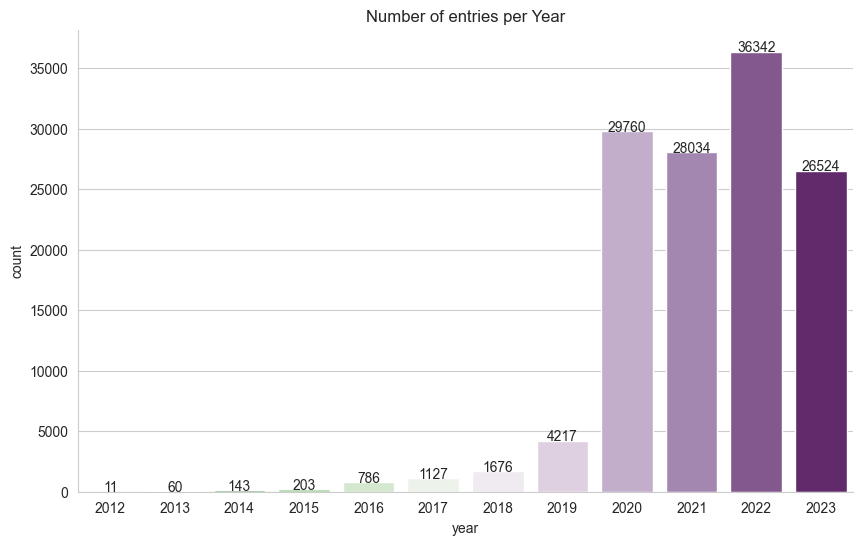

In [78]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=data, x='year', palette="PRGn_r")
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline')
sns.despine()
plt.title("Number of entries per Year")
plt.show()

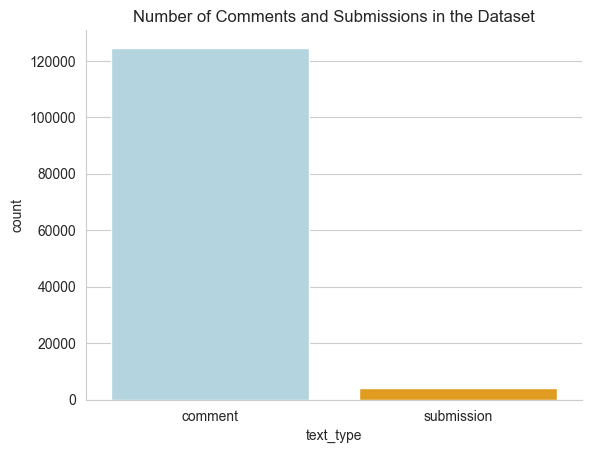

In [37]:
sns.countplot(data = data,
              x = "text_type",
              palette = ['lightblue', 'orange']
)
sns.despine()
plt.title ("Number of Comments and Submissions in the Dataset")
plt.show()

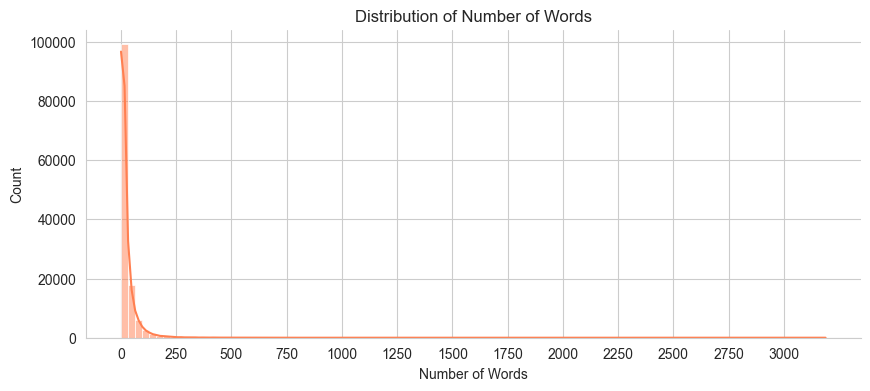

In [65]:
# Histogram for distribution of number of words in long_text
word_counts = data['long_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 4))
sns.histplot(word_counts, bins=100, kde=True, color="coral")
sns.despine()

plt.xticks(ticks = range(0, word_counts.max(), 250))
plt.title("Distribution of Number of Words")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.show()


### **Most Frequent Words**

#### **Without Removing stop words**

In [82]:
#list of all words in the dataframe
all_words = [word for sentence in data['long_text'] for word in sentence.split()]

#frequency of word occurrence
fdist = FreqDist(all_words)

common_words = fdist.most_common(20)

#table of common words
common_words_table = PrettyTable(['word', 'count'])
for word, count in common_words:
    common_words_table.add_row([word, count])

print (common_words_table)

+------+--------+
| word | count  |
+------+--------+
| the  | 121075 |
|  to  | 90303  |
|  a   | 74823  |
| and  | 72887  |
|  I   | 61390  |
|  in  | 51342  |
|  of  | 50302  |
| you  | 49058  |
|  is  | 48783  |
| for  | 37280  |
| that | 31496  |
|  it  | 30491  |
| are  | 25624  |
| have | 22552  |
|  on  | 22009  |
| not  | 21622  |
|  be  | 20362  |
| with | 20247  |
| this | 19229  |
| they | 19161  |
+------+--------+


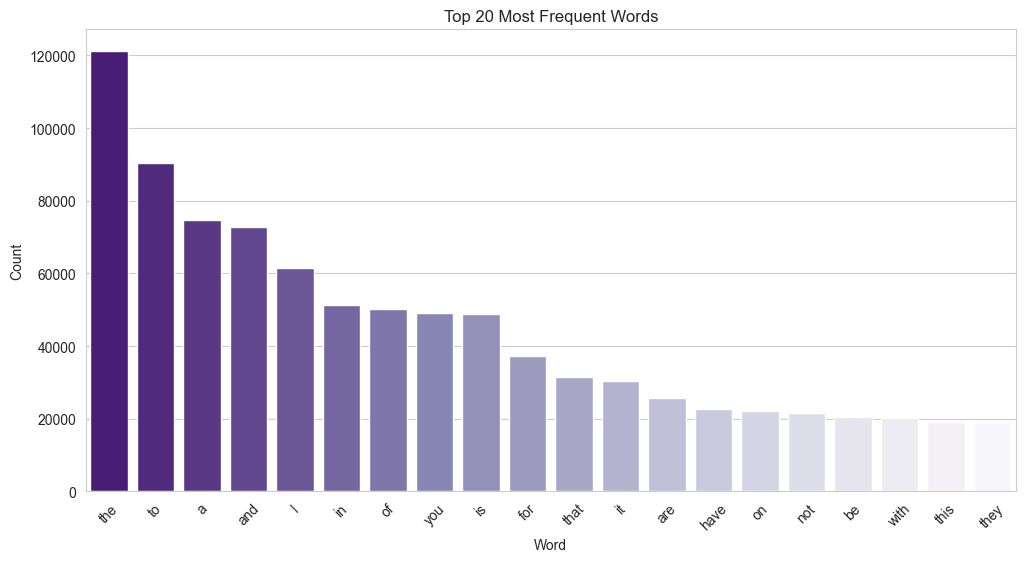

In [42]:
# Plot the top 20 words
words_df = pd.DataFrame(common_words, columns=['Word', 'Count'])
plt.figure(figsize=(12, 6))
sns.barplot(x='Word', y='Count', data=words_df, palette="Purples_r")
plt.title("Top 20 Most Frequent Words")
plt.xticks(rotation=45)
plt.show()

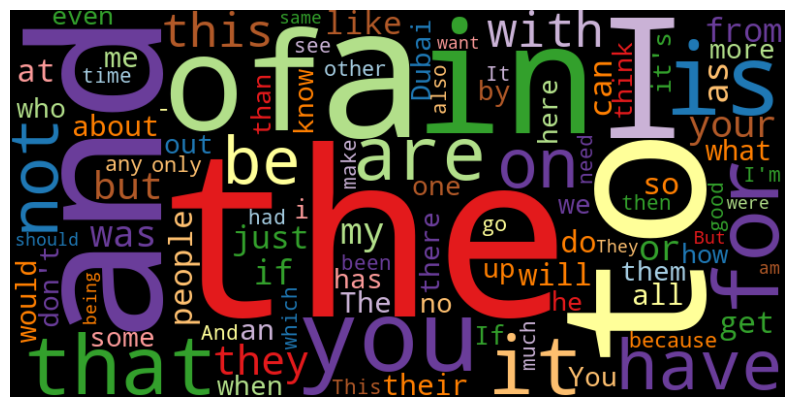

In [75]:
#wordcloud of most frequent words
# Create a dictionary of rare words and their frequencies
common_words = fdist.most_common(100)
common_word_freq = {word: freq for word, freq in common_words}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400,  background_color="black", colormap="Paired").generate_from_frequencies(common_word_freq)

# Plot the word cloud
fig = plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

#fig.savefig('word_cloud_unprocessed_data.png', dpi = 300)

plt.show()



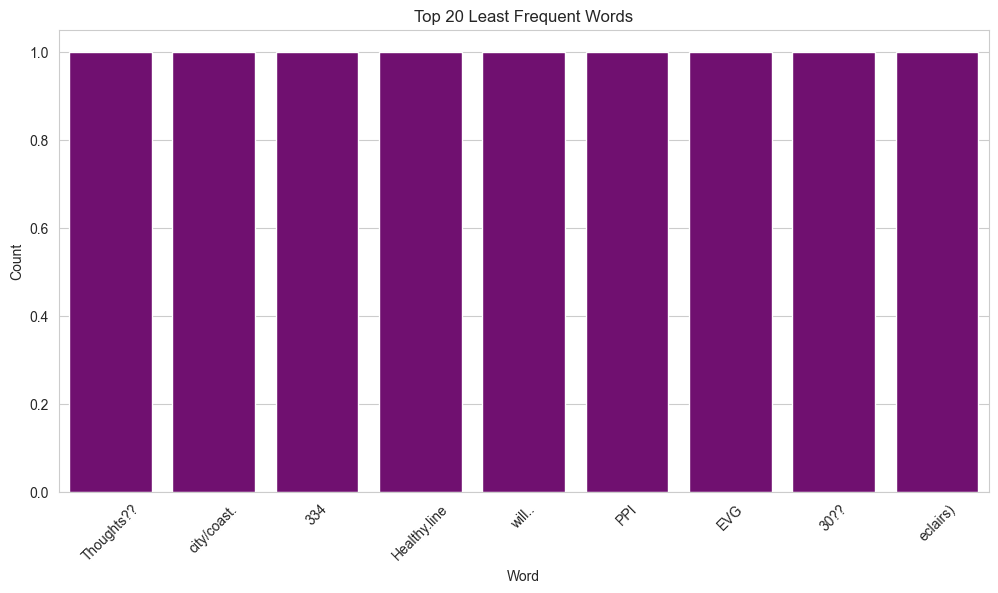

In [51]:
# Plot the top rare 20 words
rare_words = fdist.most_common()[:-10:-1]
words_df = pd.DataFrame(rare_words, columns=['Word', 'Count'])
plt.figure(figsize=(12, 6))
sns.barplot(x='Word', y='Count', data=words_df, color = "purple")
plt.title("Top 20 Least Frequent Words")
plt.xticks(rotation=45)
plt.show()

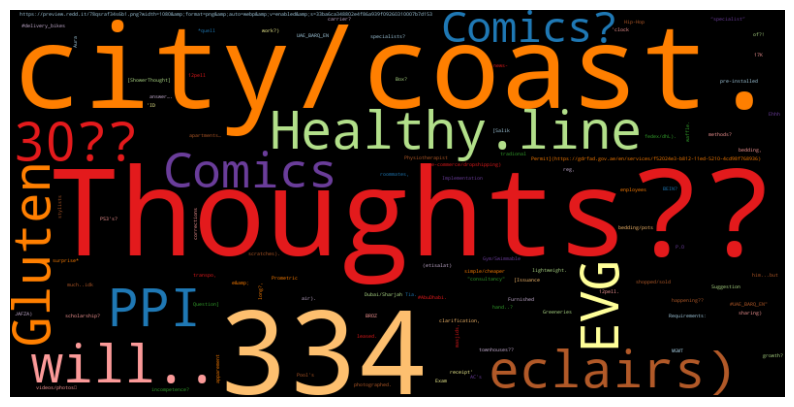

In [76]:
#a wordcloud of the rare words
rare_words = fdist.most_common()[:-100:-1]
# Create a dictionary of rare words and their frequencies
rare_word_freq = {word: freq for word, freq in rare_words}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="black", colormap="Paired").generate_from_frequencies(rare_word_freq)

# Plot the word cloud
fig = plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

fig.savefig('word_cloud_rare_words_unprocessed_data.png', dpi = 300)
plt.show()


In [73]:
#preprocessing function

#load spacy model
nlp = spacy.load('en_core_web_md')

def text_preprocess(text):
    #convert to lowercase
    text = text.lower()
    
    #remove contractions
    text = contractions.fix(text)
    
    #remove URLs
    url_pattern = r'https?://\S+'
    text = re.sub(url_pattern, ' ' ,text, flags = re.MULTILINE)
    
    #remove accents from characters
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')
    
    #remove punctuations
    text = re.sub(r'[^\w\s]', ' ', text)
    
    #remove newline and tab characters
    text = text.replace('\n', ' ').replace('\t', ' ')
    
    #remove digits
    text = ' '.join(word for word in text.split() if word.isalpha())
    
    #lemmatization
    text = ' '.join(token.lemma_ for token in nlp(text))
    
    #remove common stopwords
    text = ' '.join ([word.text for word in nlp(text) if not word.is_stop])
    
    #remove extra whitespaces
    text = re.sub('\s+', ' ',text).strip()
    
    return text

In [74]:
#apply pre-processing function to dataset
data['clean_text'] = data['long_text'].apply(text_preprocess)

data.head()

,text_type,ID,date_created,year,long_text,clean_text
0,comment,gtfo2hl,2021-04-05 13:00:32,2021,"*Cuntry roads, take me hoem*",cuntry road hoem
1,comment,gtfqkbv,2021-04-05 13:41:40,2021,"That’s been there for several years, sent a pi...",year send pic cuntry friend long time ago
2,comment,gtfou07,2021-04-05 13:13:23,2021,I am single and I have not traveled to any cun...,single travel cuntry past year
3,comment,gtfrgpe,2021-04-05 13:56:09,2021,What happens when you shop at dragon mart...,happen shop dragon mart
4,comment,gtg5mwv,2021-04-05 16:51:54,2021,I am cunting on them to do so 😅,cunte


#### **With common stopwords removed**

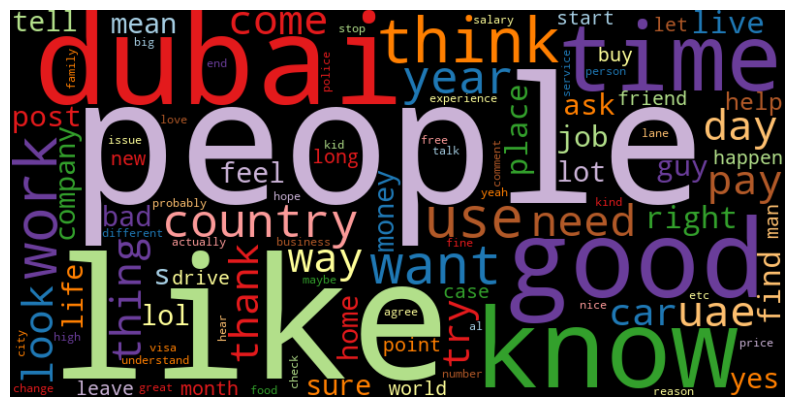

In [79]:
#wordcloud of most frequent words
#list of all words in the dataframe
all_words = [word for sentence in data['clean_text'] for word in sentence.split()]

#frequency of word occurrence
fdist = FreqDist(all_words)

# Create a dictionary of rare words and their frequencies
common_words = fdist.most_common(100)
common_word_freq = {word: freq for word, freq in common_words}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400,  background_color="black", colormap="Paired").generate_from_frequencies(common_word_freq)

# Plot the word cloud
fig = plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

#fig.savefig('word_cloud_unprocessed_data.png', dpi = 300)

plt.show()

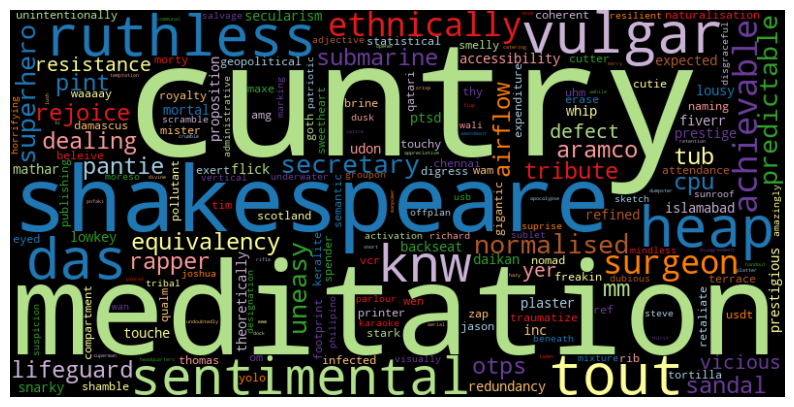

In [94]:
#a wordcloud of the rare words
# Given that fdist is already defined in your environment, create a dictionary of rare words and their frequencies
rare_words = {word: count for word, count in fdist.items() if count <= 10}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="black", colormap="Paired").generate_from_frequencies(rare_words)

# Plot the word cloud
fig = plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Save the figure (uncomment to save in your environment)
# fig.savefig('word_cloud_rare_words_unprocessed_data.png', dpi=300)

plt.show()

#### **With domain specific stopwords removed**

In [89]:
#domain specific stopwords
#list of all words in the dataframe
all_words = [word for sentence in data['clean_text'] for word in sentence.split()]

#frequency of word occurrence
fdist = FreqDist(all_words)

common_words = fdist.most_common(100)
rare_words = {word: count for word, count in fdist.items() if count <= 10}

print(dict(common_words)) 
print (rare_words)

{'people': 15221, 'like': 13862, 'dubai': 12778, 'know': 9774, 'good': 9617, 'time': 8451, 'think': 8423, 'work': 7762, 'use': 6867, 'want': 6600, 'country': 6564, 'year': 6516, 'need': 6248, 'uae': 6240, 'thing': 5807, 'pay': 5735, 'come': 5620, 'day': 5589, 'look': 5581, 'way': 5557, 'thank': 5160, 'try': 5033, 'car': 5005, 'right': 4770, 'live': 4745, 'place': 4403, 'find': 4341, 's': 4178, 'ask': 4089, 'job': 4067, 'guy': 4037, 'post': 4012, 'company': 3807, 'lot': 3747, 'mean': 3682, 'sure': 3589, 'tell': 3467, 'feel': 3443, 'life': 3372, 'yes': 3370, 'bad': 3331, 'money': 3291, 'lol': 3290, 'home': 3210, 'help': 3164, 'happen': 3145, 'month': 3055, 'new': 3006, 'let': 3002, 'drive': 2951, 'point': 2924, 'case': 2853, 'leave': 2852, 'man': 2828, 'world': 2822, 'friend': 2806, 'start': 2776, 'buy': 2721, 'long': 2688, 'experience': 2552, 'actually': 2502, 'comment': 2461, 'change': 2456, 'maybe': 2337, 'high': 2329, 'issue': 2320, 'person': 2301, 'hope': 2287, 'fine': 2272, 'food':

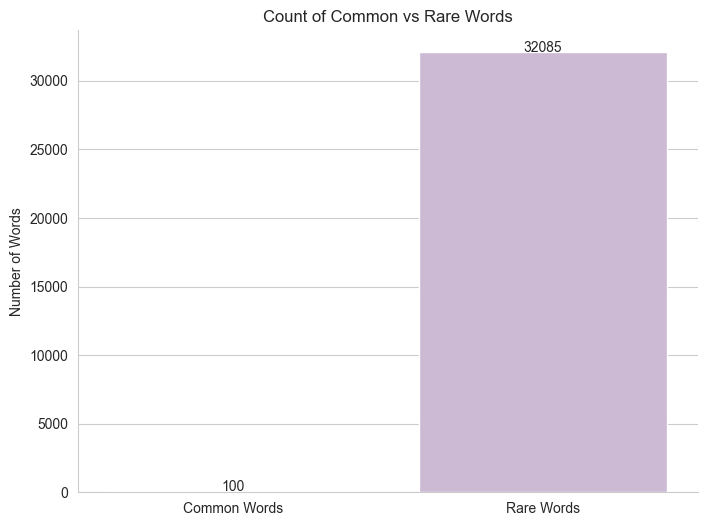

In [97]:
# Counts of common and rare words based on the dictionaries
common_words_count = len(common_words)
rare_words_count = len(rare_words)

# Categories and their counts
categories = ['Common Words', 'Rare Words']
counts = [common_words_count, rare_words_count]

# Create a barplot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=categories, y=counts, palette="PRGn_r")
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline')
sns.despine()
plt.title("Count of Common vs Rare Words")
plt.ylabel("Number of Words")
plt.show()

In [99]:
all_words = [word for sentence in data['clean_text'] for word in sentence.split()]

len(set(all_words))

40330